In [1]:
%load_ext autoreload

In [2]:
import numpy as np
from scipy import interpolate, integrate

import matplotlib.pyplot as plt

In [3]:
from PIL import Image

In [4]:
from itertools import product, permutations
import math

In [5]:
%autoreload 2
from trees.tree_things import NoiseOctave, PerlinNoiseScreen
from trees.ui import Canvas

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [6]:
screen = PerlinNoiseScreen(
    shape=(3, 3),
    seed=8337,
    octaves=2,
    magnitude=1.0,
    density=2,
)

In [39]:
a[:0]

array([], dtype=int64)

In [24]:
screen.gradient.take(
    [(8, 10), (8, 10)],
    mode="wrap"
)

array([[-0.18532735,  0.54962346],
       [-0.18532735,  0.54962346]])

In [65]:
%matplotlib inline
def examine_gradient_rendering(screen, intfunc):
    grid = intfunc(screen.gradient, corner=0)
    plot_field(grid, screen.gradient[:, :, 0], screen.gradient[:, :, 1])
    plt.show()
    plot_gradient_errors(grid, screen.gradient)

In [60]:
def integrate_from_value(val, grad, window_size):
    grid = np.zeros((window_size, window_size))
    grid[0, 0] = val
    
    for i in range(window_size):
        for j in range(window_size):
            if j > 0:
                grid[i, j] += grid[i - 1, j] + integrate.simpson(grad[i, :j, 1])
            if i > 0:
                #print(i, j)
                grid[i, j] += grid[i, j - 1] + integrate.simpson(grad[:i, j, 0])
    return grid
            
def kernel_integration(grad, corner=0, window_size=3):
    grid = np.zeros(grad.shape[:-1])
    grid[0, 0] = corner

    # expand the grid to wrap corners
    gradex = np.concatenate((
            grad,
            grad[:window_size, :, :],
        ),
        axis=0
    )
    gridex = np.concatenate((
            grid,
            grid[:window_size, :],
        ),
        axis=0
    )
    
    gradex = np.concatenate((
            gradex,
            np.concatenate((
                grad[:, :window_size, :],
                np.zeros((window_size, window_size, 2)),
            ), axis=0)
        ),
        axis=1
    )
    gridex = np.concatenate((
            gridex,
            np.concatenate((
                grid[:, :window_size],
                np.zeros((window_size, window_size)),
            ), axis=0)
        ),
        axis=1
    )
    #print(gradex.shape)
                            
    for i in range(grad.shape[0]):
        for j in range(grad.shape[1]):
            gridex[i:i+window_size, j:j+window_size] += integrate_from_value(
                grid[i, j],
                gradex[i:i+window_size, j:j+window_size, :],
                window_size
            ) / (window_size**2)

    grid = gridex[:grid.shape[0], :grid.shape[1]]
    grid[:window_size, :] += gridex[grid.shape[0]:, :grid.shape[1]]
    grid[:, :window_size] += gridex[:grid.shape[0], grid.shape[1]:]
    return grid


scalar = kernel_integration(screen.gradient)
np.sum(np.power(np.dstack(np.gradient(scalar)) - screen.gradient, 2))

47.18399012073546

In [55]:
integrate_from_value(
    0,
    integrate.simpson(screen.gradient[:2, 2, 0]),
    

0.33119920432567596

In [45]:
pass

In [11]:
def render_scalar_field(grad, corner=0):
    grid = np.zeros(grad.shape[:-1])
    grid[0, 0] = corner
    
    for i in range(grad.shape[0] - 1):
        grid[i+1, 0] = grid[i, 0] + integrate.simpson(grad[:i, 0, 0])
        for j in range(grad.shape[1] - 1):
            grid[i+1, j+1] = grid[i+1, j] + integrate.simpson(grad[i, :j, 1])
    return grid


scalar = render_scalar_field(screen.gradient)
#np.sum(np.power(np.dstack(np.gradient(scalar)) - screen.gradient, 2))

IndexError: index -1 is out of bounds for axis 0 with size 0

In [34]:
grid.shape

(6, 6)

In [35]:
screen.gradient.shape

(6, 6, 2)

In [36]:
gx, gy = np.gradient(grid)

In [37]:
gx.shape

(6, 6)

In [47]:
grad = np.dstack(np.gradient(grid))

In [51]:
scalar = render_scalar_field(grad)

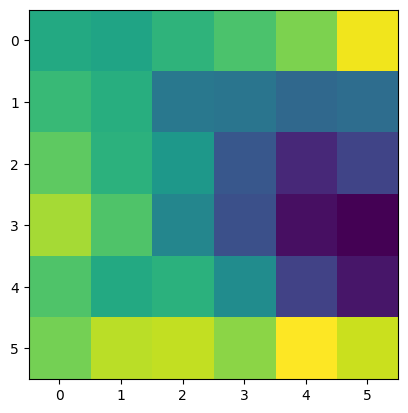

In [50]:
plt.imshow(grid)

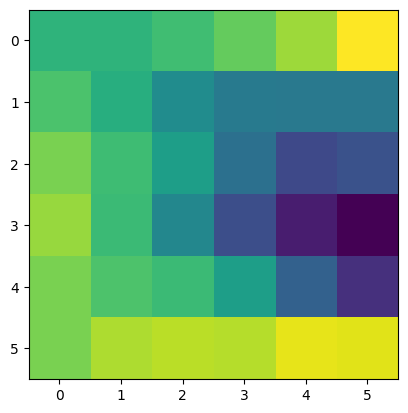

In [52]:
plt.imshow(scalar)

2.683988623414053

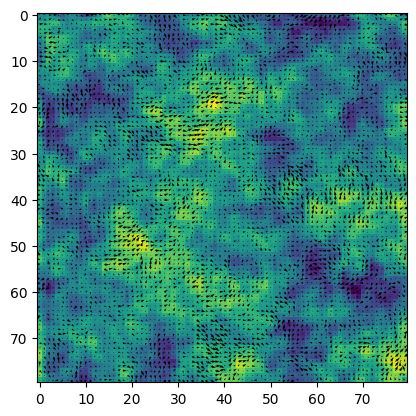

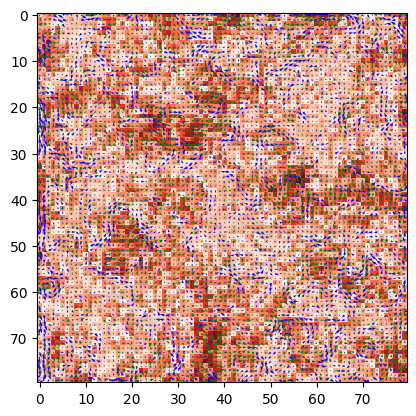

In [70]:
examine_gradient_rendering(
    PerlinNoiseScreen(
        shape=(5, 5),
        seed=10003,
        octaves=5,
        magnitude=1.0,
        density=2,
    ),
    kernel_integration
)

In [12]:
grid = render_scalar_field(screen.gradient)

In [61]:
%matplotlib inline

def plot_field(grid, grad_x, grad_y):
    plt.imshow(grid)
    plt.quiver(grad_x, grad_y)

In [62]:
%matplotlib inline

def plot_gradient_errors(grid, sgrad):
    np.dstack(np.gradient(grid)).shape
    g = np.dstack(np.gradient(grid, edge_order=2))
    
    dx = g[:, :, 0] - sgrad[:, :, 0]
    dy = g[:, :, 1] - sgrad[:, :, 1]
    
    plt.imshow(
        np.sqrt(np.square(dx) + np.square(dy)),
        cmap="Reds",
    )
    plt.quiver(
        g[:, :, 0],
        g[:, :, 1],
        color="b",
    )
    plt.quiver(
        sgrad[:, :, 0],
        sgrad[:, :, 1],
        color="g",
    )

In [120]:
np.concatenate((g_x, g_y), axis=1).shape

(6, 12)

In [43]:
interpolator = interpolate.RegularGridInterpolator(
    [np.linspace(0, 1, num=d) for d in grid.shape],
    grid,
    method="linear",
    bounds_error=True,
)


In [47]:
points = np.array([np.linspace(0, 1, num=10) for _ in grid.shape])

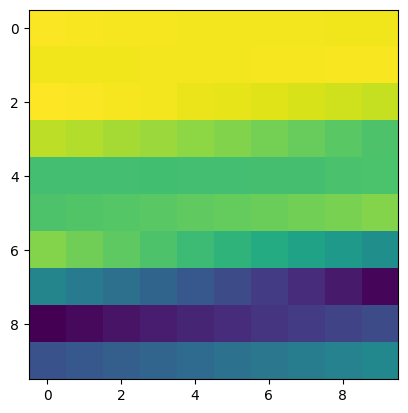

In [60]:
L = 10
pts = interpolator(np.linspace(0, 1, num=(2*L**2)))
ngrid = pts.reshape((L, L), order="A")
plt.imshow(ngrid)

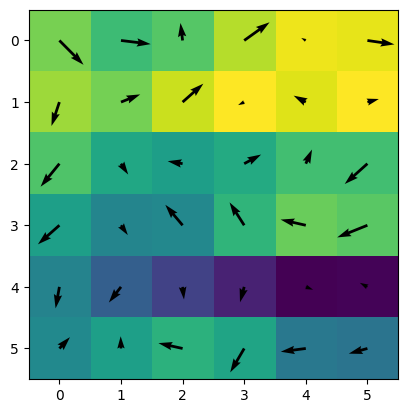

In [75]:
plt.imshow(grid)
plt.quiver(
    screen.gradient[:, :, 0],
    screen.gradient[:, :, 1],
)

In [69]:
grid.shape

(6, 6)

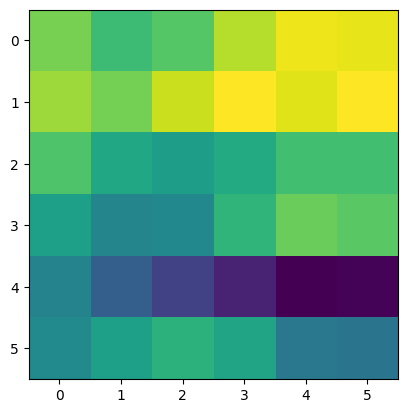

In [74]:
shp = grid.shape
recon = grid.flatten()
plt.imshow(recon.reshape())

In [76]:
def interp(x, xp, fp):
    i = np.arange(x.size)
    j = np.searchsorted(xp, x) - 1
    d = (x - xp[j]) / (xp[j + 1] - xp[j])
    return (1 - d) * fp[i, j] + fp[i, j + 1] * d

## This may be Useful
  + <https://docs.scipy.org/doc/scipy/reference/ndimage.html>

In [77]:
from scipy import ndimage


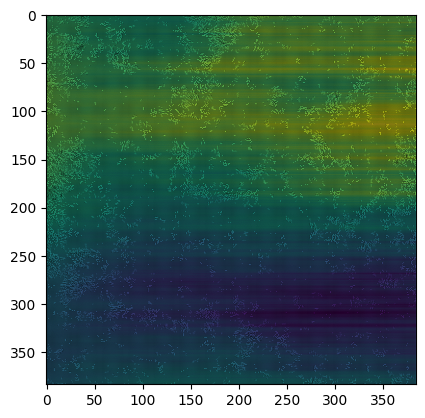

In [85]:
plt.imshow(grid)
plt.quiver(
    screen.gradient[:, :, 0],
    screen.gradient[:, :, 1],
)

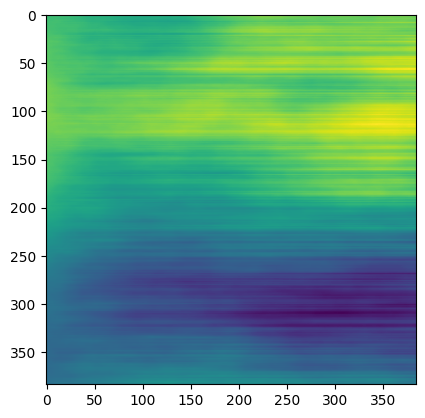

In [88]:
plt.imshow(ndimage.zoom(grid, 1))

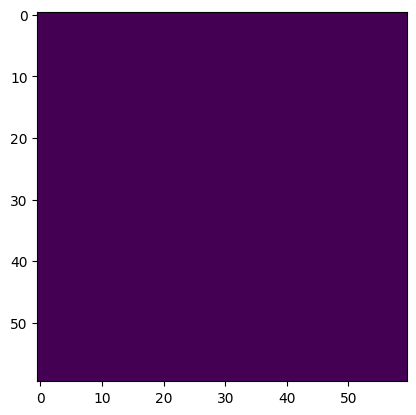

In [66]:
def interpolate_grid(grid: np.ndarray, scale: int) -> np.ndarray:
    upscaled_grid = np.zeros([
        d*scale
        for d in grid.shape
    ])

    def func(

    return upscaled_grid

plt.imshow(
    interpolate_grid(grid, 10)
)

In [124]:
canvas_size = 500
render_size = 11+1
canvas = Canvas.perlin_noise_canvas(
    shape=(3, 3),
    size=canvas_size,
    render_size=render_size,
    seed=1337,
    octaves=2,
    magnitude=1.0,
    density=2,
)

In [91]:
screen.gradient.shape[:-1]

(6, 6)

In [107]:
For a more abstract exampleint(1.9)

1

In [102]:
list(zip(
    np.linspace((0, 0), (0, 100), num=11),
    np.linspace((100, 0), (100, 100), num=11),
))

[(array([0., 0.]), array([100.,   0.])),
 (array([ 0., 10.]), array([100.,  10.])),
 (array([ 0., 20.]), array([100.,  20.])),
 (array([ 0., 30.]), array([100.,  30.])),
 (array([ 0., 40.]), array([100.,  40.])),
 (array([ 0., 50.]), array([100.,  50.])),
 (array([ 0., 60.]), array([100.,  60.])),
 (array([ 0., 70.]), array([100.,  70.])),
 (array([ 0., 80.]), array([100.,  80.])),
 (array([ 0., 90.]), array([100.,  90.])),
 (array([  0., 100.]), array([100., 100.]))]

array([[100.        ,   0.        ],
       [100.        ,  11.11111111],
       [100.        ,  22.22222222],
       [100.        ,  33.33333333],
       [100.        ,  44.44444444],
       [100.        ,  55.55555556],
       [100.        ,  66.66666667],
       [100.        ,  77.77777778],
       [100.        ,  88.88888889],
       [100.        , 100.        ]])

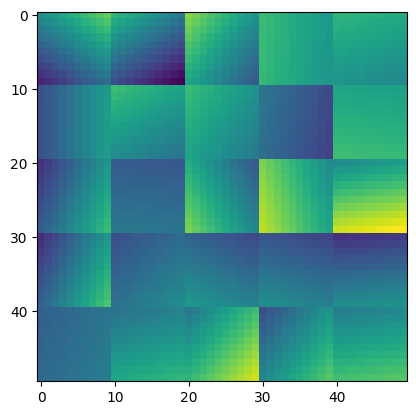

In [86]:
plt.imshow(
    canvas.misc.screen.render_noise(render_size, normalize=True)
)

In [80]:
canvas.misc.screen.render_noise(render_size, normalize=True).shape

(50, 50)

In [87]:
canvas.image.pixels.shape

(500, 500, 3)

In [83]:
canvas.image.internal_size

(0, 0)

In [84]:
For a more abstract examplecanvas.image.size

(10, 10)

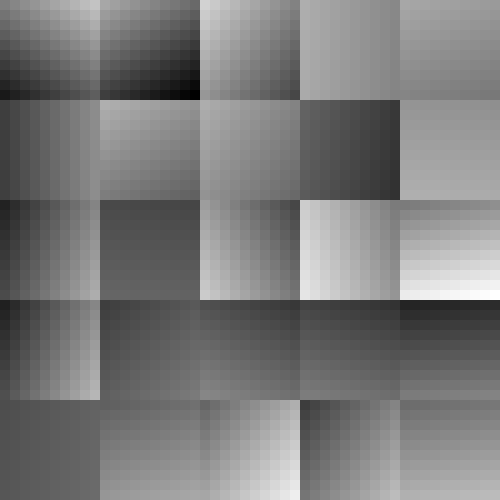

In [88]:
Image.fromarray(canvas.image.pixels, mode="RGB")

In [38]:
canvas.image.pixels.shape

(500, 500, 3)

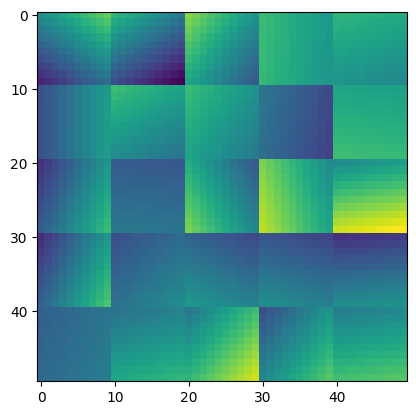

In [50]:
plt.imshow(screen.render_noise(10))self.scale_grid(size[1], int(

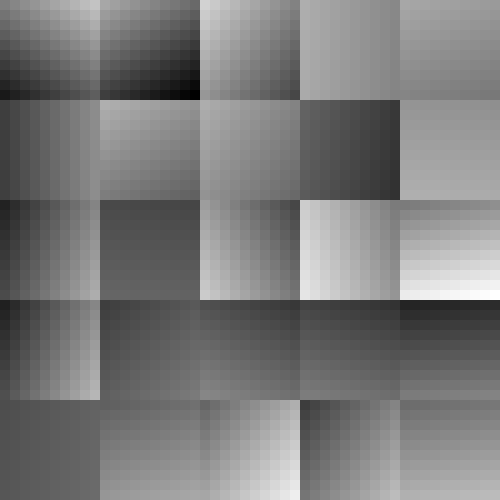

In [109]:
Image.fromarray(canvas.image.pixels, mode="RGB")

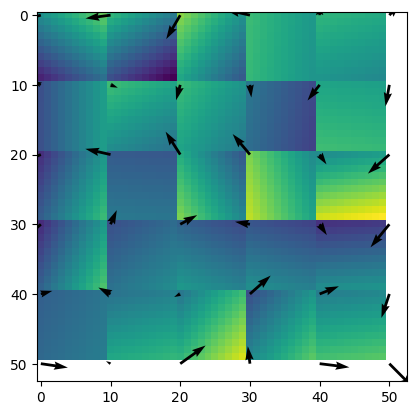

In [114]:
plt.imshow(canvas.image.data_layers[0][0])
plt.quiver(
    np.linspace(0, 50, 6),
    np.linspace(0, 50, 6),
    canvas.misc.screen.gradient[::-1, ::-1, 0],
    canvas.misc.screen.gradient[::-1, ::-1, 1],
)

In [118]:
list(product([0, 1], repeat=1+1))

[(0, 0), (0, 1), (1, 0), (1, 1)]

In [119]:
1+1

2

In [17]:
screen.render_noise(10).min()

0.0

In [136]:
canvas.misc.screen.stencil(canvas.misc.render_size)[0][1][8, 9]

array([0.72727273, 0.81818182])

In [67]:
layer.mesh

[array([[0.        , 0.33333333, 0.66666667, 1.        ],
        [0.        , 0.33333333, 0.66666667, 1.        ],
        [0.        , 0.33333333, 0.66666667, 1.        ],
        [0.        , 0.33333333, 0.66666667, 1.        ]]),
 array([[0.        , 0.        , 0.        , 0.        ],
        [0.33333333, 0.33333333, 0.33333333, 0.33333333],
        [0.66666667, 0.66666667, 0.66666667, 0.66666667],
        [1.        , 1.        , 1.        , 1.        ]])]

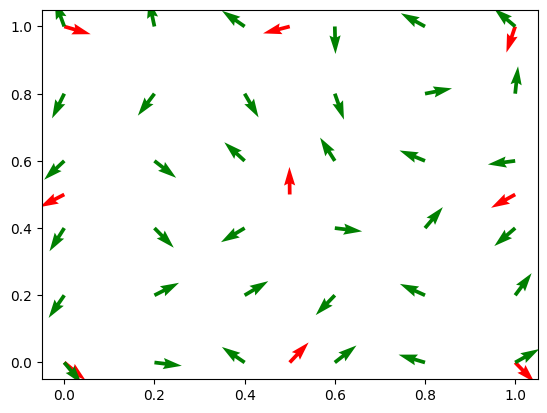

In [213]:
colors = "rgbcm"
for i, layer in enumerate(screen.octave_layers):
    plt.quiver(
        *layer.mesh,
        layer.gradient_grid[:, :, 0],
        layer.gradient_grid[:, :, 1],
        color=colors[i],
    )

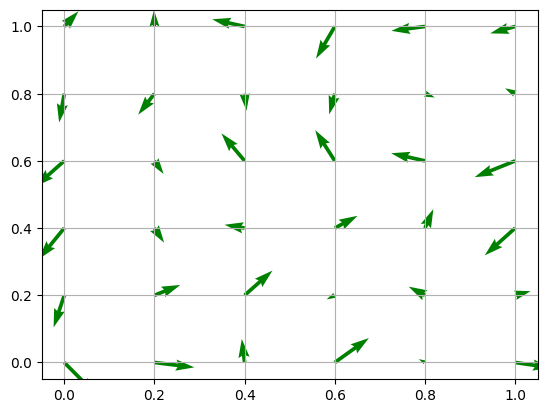

In [215]:
plt.quiver(
    *screen.octave_layers[-1].mesh,
    screen.gradient[:, :, 0],
    screen.gradient[:, :, 1],
    color=colors[i],
)
plt.grid()

In [221]:
screen.gradient.shape

(6, 6, 2)

In [228]:
[
    screen.gradient[0, 0, :],
    screen.gradient[0, 1, :],
    screen.gradient[1, 0, :],
    screen.gradient[1, 1, :],
]

[array([ 1.40292454, -1.41270733]),
 array([ 1.72849529, -0.21203132]),
 array([-0.46221608, -1.39021924]),
 array([1.11812917, 0.44700239])]

In [328]:
N = 10
mgrid = np.array(list(product(
    *(np.linspace(0, 1, num=N) for _ in range(2))
))).T

In [329]:
scalar = np.sum([
    np.dot(g[idx], mgrid)
    for idx in product([0, 1], [0, 1])
], axis=0).reshape((N, N))

In [340]:
lst = []
for i in range(3):
    g = screen.gradient[i:i+2, j:j+2, :]
    scalar = np.sum([
        np.dot(g[idx], mgrid)
        for idx in product([0, 1], [0, 1])
    ], axis=0).reshape((N, N))
    lst.append(scalar)

In [343]:
vals = np.concatenate(lst, axis=1)

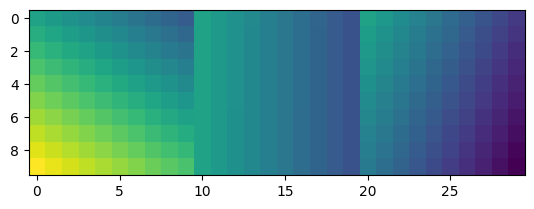

In [344]:
plt.imshow(vals)

In [380]:
np.matmul([[1, 0], [0, -1]], mgrid)

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.11111111,  0.11111111,  0.11111111,  0.11111111,  0.11111111,
         0.11111111,  0.11111111,  0.11111111,  0.11111111,  0.11111111,
         0.22222222,  0.22222222,  0.22222222,  0.22222222,  0.22222222,
         0.22222222,  0.22222222,  0.22222222,  0.22222222,  0.22222222,
         0.33333333,  0.33333333,  0.33333333,  0.33333333,  0.33333333,
         0.33333333,  0.33333333,  0.33333333,  0.33333333,  0.33333333,
         0.44444444,  0.44444444,  0.44444444,  0.44444444,  0.44444444,
         0.44444444,  0.44444444,  0.44444444,  0.44444444,  0.44444444,
         0.55555556,  0.55555556,  0.55555556,  0.55555556,  0.55555556,
         0.55555556,  0.55555556,  0.55555556,  0.55555556,  0.55555556,
         0.66666667,  0.66666667,  0.66666667,  0.66666667,  0.66666667,
         0.66666667,  0.66666667,  0.66666667,  0.6

In [450]:
scalar = np.sum([
    np.dot(g[0, 0], g00),
    np.dot(g[0, 1], g01),
    np.dot(g[1, 0], g10),
    np.dot(g[1, 1], g11),
], axis=0).reshape((N, N))
plt.imshow(
    scalar,
    extent=(0, 1, 1, 0),
    cmap="viridis",
)
plt.quiver(
    [0.05, 0.95],
    [0.05, 0.95],
    g[:, :, 0],
    g[:, :, 1],
)
plt.show()

ValueError: shapes (2,) and (5,5,2) not aligned: 2 (dim 0) != 5 (dim 1)

In [36]:
1+1

2

In [424]:
n = 5
r = np.linspace(0, n-1, num=n)
v = np.array(list(product(r, r))).reshape((n, n, 2))

In [428]:
v[3, 4]

array([3., 4.])

In [479]:
N = 15
mgrid = np.array(list(product(
    *(np.linspace(0, 1, num=N) for _ in range(2))
))).reshape((N, N, 2))

In [480]:
g00 = mgrid.copy()

g01 = mgrid[:, ::-1, :].copy()
g01[:, :, 0] *= -1

g10 = mgrid[::-1, :, :].copy()
g10[:, :, 1] *= -1

g11 = mgrid[::-1, ::-1, :].copy()
g11[:, :, :] *= -1

In [495]:
list(product([0, 1], repeat=3))

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [520]:
list(product([1, -1], repeat=3))

[(1, 1, 1),
 (1, 1, -1),
 (1, -1, 1),
 (1, -1, -1),
 (-1, 1, 1),
 (-1, 1, -1),
 (-1, -1, 1),
 (-1, -1, -1)]

In [525]:
k = 1+1
lst = []
for idx in product([1, -1], repeat=k):
    grid = mgrid[tuple([
        slice(None, None, unit)
        for unit in idx
    ] + [slice(None, None, None)])].copy()
    for unit in idx:
        grid[idx] *= unit
    lst.append(grid)

In [517]:
idx = tuple([
    slice(None, None, -1 if bit == "1" else 1)
    for bit in "01"
] + [slice(None, None, None)])
mgrid[idx]

array([[[0.        , 1.        ],
        [0.        , 0.92857143],
        [0.        , 0.85714286],
        [0.        , 0.78571429],
        [0.        , 0.71428571],
        [0.        , 0.64285714],
        [0.        , 0.57142857],
        [0.        , 0.5       ],
        [0.        , 0.42857143],
        [0.        , 0.35714286],
        [0.        , 0.28571429],
        [0.        , 0.21428571],
        [0.        , 0.14285714],
        [0.        , 0.07142857],
        [0.        , 0.        ]],

       [[0.07142857, 1.        ],
        [0.07142857, 0.92857143],
        [0.07142857, 0.85714286],
        [0.07142857, 0.78571429],
        [0.07142857, 0.71428571],
        [0.07142857, 0.64285714],
        [0.07142857, 0.57142857],
        [0.07142857, 0.5       ],
        [0.07142857, 0.42857143],
        [0.07142857, 0.35714286],
        [0.07142857, 0.28571429],
        [0.07142857, 0.21428571],
        [0.07142857, 0.14285714],
        [0.07142857, 0.07142857],
        [0.0

In [511]:
k = 4
np.array([
    "".join(s) for s in product("01", repeat=k)
]).reshape([2 for _ in range(k)])

array([[[['0000', '0001'],
         ['0010', '0011']],

        [['0100', '0101'],
         ['0110', '0111']]],


       [[['1000', '1001'],
         ['1010', '1011']],

        [['1100', '1101'],
         ['1110', '1111']]]], dtype='<U4')

In [483]:
G = np.array([
    [g00, g01],
    [g10, g11],
])

In [408]:
g00[0, 1]

array([0., 0.])

In [405]:
g11[0, 0]

array([-1., -1.])

In [488]:
list(product(*[[0, 1]]*2))

[(0, 0), (0, 1), (1, 0), (1, 1)]

In [39]:
screen.stencil(10)

[((1, 1),
  array([[[0.        , 0.        ],
          [0.        , 0.11111111],
          [0.        , 0.22222222],
          [0.        , 0.33333333],
          [0.        , 0.44444444],
          [0.        , 0.55555556],
          [0.        , 0.66666667],
          [0.        , 0.77777778],
          [0.        , 0.88888889],
          [0.        , 1.        ]],
  
         [[0.11111111, 0.        ],
          [0.11111111, 0.11111111],
          [0.11111111, 0.22222222],
          [0.11111111, 0.33333333],
          [0.11111111, 0.44444444],
          [0.11111111, 0.55555556],
          [0.11111111, 0.66666667],
          [0.11111111, 0.77777778],
          [0.11111111, 0.88888889],
          [0.11111111, 1.        ]],
  
         [[0.22222222, 0.        ],
          [0.22222222, 0.11111111],
          [0.22222222, 0.22222222],
          [0.22222222, 0.33333333],
          [0.22222222, 0.44444444],
          [0.22222222, 0.55555556],
          [0.22222222, 0.66666667],
          

In [54]:
list(np.ndindex(*screen.gradient.shape[:-1]))

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5)]

In [66]:
i = 0
j = 0
gs = screen.gradient[i:i+2, j:j+2, :]
gs

array([[[ 1.40292454, -1.41270733],
        [ 1.72849529, -0.21203132]],

       [[-0.46221608, -1.39021924],
        [ 1.11812917,  0.44700239]]])

In [149]:
screen = PerlinNoiseScreen(
    shape=(3, 3),
    seed=1337,
    octaves=2,
    magnitude=1.0,
    density=2,
)

In [175]:
i = 2
print(screen.stencil(3)[i][0])
print(screen.stencil(3)[i][1][2, 2])

(1, 0)
[-0.  1.]


In [189]:
round

<function round(number, ndigits=None)>

In [238]:
k = 10
fin = np.zeros([(d+1)*k for d in screen.gradient.shape[:-1]])

In [224]:
def interpolate(a: float, b: float, w: float) -> float:
    w = max(min(w, 1), 0)
    return (b - a) * (3 - w * 2) * w * w + a

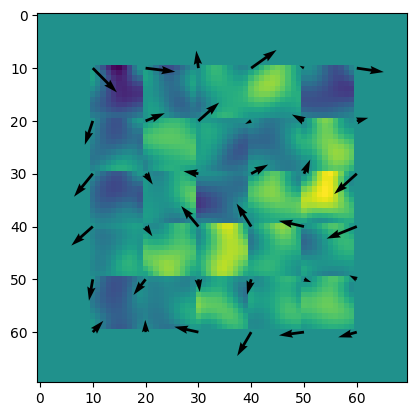

In [241]:
test = np.zeros([(d-1)*k for d in screen.gradient.shape[:-1]])
for idx in np.ndindex(test.shape):
    i = idx[0] / k
    j = idx[1] / k
    V = [
        np.array([i - int(i+0), j - int(j+0)]),
        np.array([i - int(i+0), j - int(j+1)]),
        np.array([i - int(i+1), j - int(j+0)]),
        np.array([i - int(i+1), j - int(j+1)]),
    ]
    d0 = np.dot(screen.gradient[int(i+0), int(j+0)], V[0])
    d1 = np.dot(screen.gradient[int(i+1), int(j+0)], V[1])
    d2 = np.dot(screen.gradient[int(i+0), int(j+1)], V[2])
    d3 = np.dot(screen.gradient[int(i+1), int(j+1)], V[3])

    da = interpolate(d0, d1, norm(V[0]))
    db = interpolate(d0, d2, norm(V[0]))
    dc = interpolate(d0, d3, norm(V[0]))

    dx = interpolate(da, db, norm(V[1]))
    dy = interpolate(db, dc, norm(V[2]))
    test[idx] = interpolate(dx, dy, norm(V[1]))
fin = np.zeros([(d+1)*k for d in screen.gradient.shape[:-1]])
fin[k:k*6, k:k*6] = test
plt.imshow(fin)
plt.quiver(
    np.linspace(k, k*6, 6),
    np.linspace(k, k*6, 6),
    screen.gradient[:, :, 0],
    screen.gradient[:, :, 1],
)

In [242]:
from PIL import Image

In [260]:
imgf = (((fin + 1) / 2) * 255).astype(np.int8)

In [281]:
irgb = np.array([imgf, imgf, imgf])
irgb = irgb.reshape(70, 70, 3)
irgb = np.clip(irgb, a_min=0, a_max=255)

In [282]:
irgb.shape

(70, 70, 3)

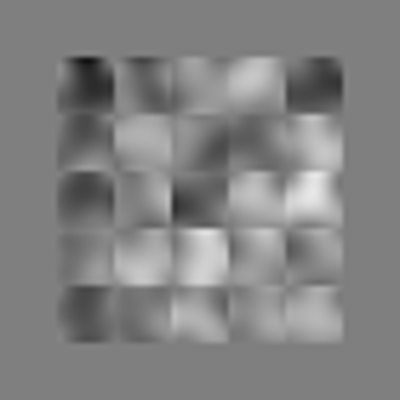

In [288]:
img = Image.fromarray(imgf, mode="L").resize((400, 400))
img

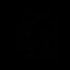

In [257]:
img

In [209]:
np.array([1, 1])

array([1, 1])

In [210]:
norm = np.linalg.norm

In [154]:
for idx in np.ndindex(*[i-1 for i in screen.gradient.shape[:-1]]):
    g = screen.gradient[
        tuple([
            slice(i, i+2, None)
            for i in idx
        ] + [slice(None, None, None)])
    ]
    val = np.sum([
        np.dot(cube, g[idx])
        for idx, cube in screen.stencil(10)
    ], axis=0)
    fin[
        tuple([
            slice((k*i+10), (k*i+10)+k, None)
            for i in idx
        ])
    ] = val[::-1, ::-1]

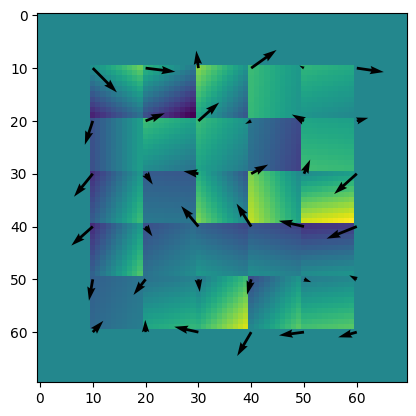

In [155]:
plt.imshow(fin)
plt.quiver(
    np.linspace(10, 60, 6),
    np.linspace(10, 60, 6),
    screen.gradient[:, :, 0],
    screen.gradient[:, :, 1],
)

In [103]:
np.linspace(0, 50, 6)

array([ 0., 10., 20., 30., 40., 50.])

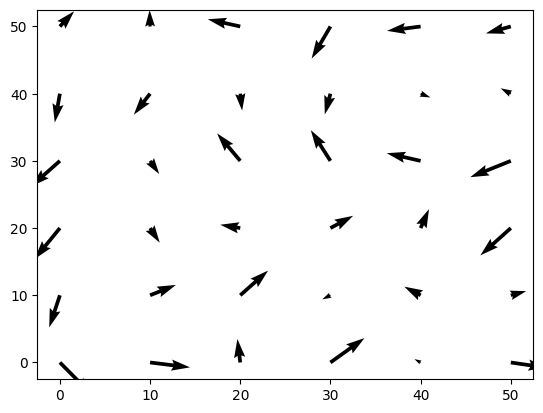

In [104]:
plt.quiver(
    np.linspace(0, 50, 6),
    np.linspace(0, 50, 6),
    screen.gradient[:, :, 0],
    screen.gradient[:, :, 1],
)

In [83]:
fin

array([[-0.32849326, -0.61382165, -0.89915004, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09232151, -0.19300688, -0.47833527, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.51313628,  0.22780789, -0.0575205 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [69]:
val = np.sum([
    np.dot(cube, g[idx])
    for idx, cube in screen.stencil(10)
], axis=0)

In [206]:
np.gradient(screen.gradient)[2]

array([[[-2.98004593, -2.98004593],
        [-2.75700942, -2.75700942],
        [-0.14568403, -0.14568403],
        ...,
        [-0.13010281, -0.13010281],
        [-1.02043132, -1.02043132],
        [ 1.81452242,  1.81452242]],

       [[-2.71920883, -2.71920883],
        [-0.29975557, -0.29975557],
        [-1.58763117, -1.58763117],
        ...,
        [ 1.92188104,  1.92188104],
        [-0.70813537, -0.70813537],
        [ 2.0111679 ,  2.0111679 ]],

       [[-1.61500416, -1.61500416],
        [-0.13144603, -0.13144603],
        [-1.51297752, -1.51297752],
        ...,
        [ 0.05144848,  0.05144848],
        [ 0.64629327,  0.64629327],
        [ 2.56896443,  2.56896443]],

       ...,

       [[-1.92622664, -1.92622664],
        [ 0.0129927 ,  0.0129927 ],
        [-0.71152741, -0.71152741],
        ...,
        [-1.08140008, -1.08140008],
        [-0.7529786 , -0.7529786 ],
        [-1.66212841, -1.66212841]],

       [[-2.09707445, -2.09707445],
        [-1.00437322, -1.00

In [91]:
interpolator = interpolate.RegularGridInterpolator(
    [np.linspace(0, 1, num=d) for d in layer.shape],
    layer.gradient_grid,
    method="linear",
    bounds_error=True,
)

In [92]:
layer.mesh[0].shape

(4, 4)

In [217]:
i = 1
ilayer = screen.octave_layers[i]

In [117]:
grid = np.meshgrid(
    *(
        np.linspace(0, 1, num=ilayer.shape[d])
        for d in range(ilayer.dimensions)
    ),
    indexing="ij"
)
grid

[array([[0.        , 0.        , 0.        , 0.        ],
        [0.33333333, 0.33333333, 0.33333333, 0.33333333],
        [0.66666667, 0.66666667, 0.66666667, 0.66666667],
        [1.        , 1.        , 1.        , 1.        ]]),
 array([[0.        , 0.33333333, 0.66666667, 1.        ],
        [0.        , 0.33333333, 0.66666667, 1.        ],
        [0.        , 0.33333333, 0.66666667, 1.        ],
        [0.        , 0.33333333, 0.66666667, 1.        ]])]

In [124]:
ilayer.mesh[0]

array([[0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ]])

In [176]:
grid = np.array(list(product(*(
    np.linspace(0, 1, num=d)
    for d in ilayer.shape
)))).reshape([*ilayer.shape, 2])

In [162]:
grid = np.array(list(product(
        np.linspace(0, 1, num=6),
        np.linspace(0, 1, num=6),
)))

In [163]:
#ilayer.gradient_grid.shape
g1 = grid.reshape((6, 6, 2))
g1

array([[[0. , 0. ],
        [0. , 0.2],
        [0. , 0.4],
        [0. , 0.6],
        [0. , 0.8],
        [0. , 1. ]],

       [[0.2, 0. ],
        [0.2, 0.2],
        [0.2, 0.4],
        [0.2, 0.6],
        [0.2, 0.8],
        [0.2, 1. ]],

       [[0.4, 0. ],
        [0.4, 0.2],
        [0.4, 0.4],
        [0.4, 0.6],
        [0.4, 0.8],
        [0.4, 1. ]],

       [[0.6, 0. ],
        [0.6, 0.2],
        [0.6, 0.4],
        [0.6, 0.6],
        [0.6, 0.8],
        [0.6, 1. ]],

       [[0.8, 0. ],
        [0.8, 0.2],
        [0.8, 0.4],
        [0.8, 0.6],
        [0.8, 0.8],
        [0.8, 1. ]],

       [[1. , 0. ],
        [1. , 0.2],
        [1. , 0.4],
        [1. , 0.6],
        [1. , 0.8],
        [1. , 1. ]]])

In [179]:
pts = interpolator(grid)
pts

array([[[ 0.76883382, -0.63944864],
        [ 0.74621161, -0.2665874 ],
        [ 0.7235894 ,  0.10627384],
        [ 0.7009672 ,  0.47913507],
        [ 0.68698373,  0.59645084],
        [ 0.69027774,  0.20267567],
        [ 0.69357176, -0.1910995 ],
        [ 0.69686577, -0.58487467],
        [ 0.40953448, -0.6693953 ],
        [-0.02310946, -0.59928865],
        [-0.4557534 , -0.52918201],
        [-0.88839734, -0.45907536]],

       [[ 0.55627045, -0.1923415 ],
        [ 0.47549435, -0.03150639],
        [ 0.39471824,  0.12932872],
        [ 0.31394214,  0.29016384],
        [ 0.30639335,  0.30696657],
        [ 0.44529921,  0.03570454],
        [ 0.58420507, -0.23555749],
        [ 0.72311093, -0.50681952],
        [ 0.46404588, -0.56180013],
        [ 0.00599538, -0.50864003],
        [-0.45205512, -0.45547993],
        [-0.91010562, -0.40231983]],

       [[ 0.34370709,  0.25476564],
        [ 0.20477709,  0.20357463],
        [ 0.06584708,  0.15238361],
        [-0.07308292,  0